# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 6: Análisis de sentimientos

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 5 de septiembre de 2024


### 🚨 Se puede descargar manualmente el dataset mediante el enlace de abajo o ejecutando el código proporcionado. (Es necesario una cuenta y una key de kaggle). Es importante descomprimir el archivo en la carpeta data.

In [5]:
import os
import opendatasets as od
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from collections import Counter
import seaborn as sns
from matplotlib_venn import venn2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 🌋 Ejercicio 1

In [2]:
def printText(df, stop = 10):
    for i, t in enumerate(df):
        print(i, t)
        if i >= stop:
            break

### 📩 Inciso 1. Descargar el archivo train.csv

In [3]:
if not os.path.isdir('nlp-getting-started'):
    od.download("https://www.kaggle.com/c/nlp-getting-started/data")

### 📩 Inciso 2. Carga de los datos

In [4]:
dataTrain = pd.read_csv('nlp-getting-started/train.csv')
dataTest = pd.read_csv('nlp-getting-started/test.csv')
dataSampleSubmission = pd.read_csv('nlp-getting-started/sample_submission.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [5]:
dataTrain.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
dataTrain.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
for i, element in enumerate(dataTrain.columns):
    print(str(i+1)+")📚["+element+"].Count:", dataTrain[element].count())

1)📚[id].Count: 7613
2)📚[keyword].Count: 7552
3)📚[location].Count: 5080
4)📚[text].Count: 7613
5)📚[target].Count: 7613


In [8]:
text = dataTrain['text']

Comenzando con este laboratorio lo primero que se hizo fue una limpieza y preprocesamiento de los datos, los cuales nos ayudarán para una mejor predicción de los mismos a la hora que nuestros modelos tengan que leer y clasificar los tweets.

Un poco de lo que realizamos para su limpieza fue:
- Eliminación de URLs presentes en los tweets para evitar que estos influyan en procesos posteriores
- Conversión a minúsculas de los textos para normalizar los datos.
- Eliminación de caracteres especiales para limpiar el texto y enfocarse en palabras
- Eliminación de patrones extraños como múltiples signos de exclamación, caracteres como **&** ya que se presentaban como **&amp** y saltos de líneas reemplazados por espacios.
- Reducción de repetición de letras consecutivamente así como **gooooaaaal** se normalizo a la palabra original **goal**.
- Eliminación de puntos y coma.
- Eliminación de espacios en blanco extras dejando solamente uno.
- Eliminación de stopwords, es decir palabras comunes que no aportan mucho significado pro sí solas, enfocandonos en palabras más significativas del texto.

Todo lo descrito anteriormente se puede ver el procedimiento a continuación:

#### 🖼️ Removiendo urls

In [9]:
textWithoutUrl = text.str.replace(r'http\S+|www\S+', '', regex=True)
printText(textWithoutUrl, 100)

0 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1 Forest fire near La Ronge Sask. Canada
2 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3 13,000 people receive #wildfires evacuation orders in California 
4 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5 #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6 #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7 I'm on top of the hill and I can see a fire in the woods...
8 There's an emergency evacuation happening now in the building across the street
9 I'm afraid that the tornado is coming to our area...
10 Three people died from the heat wave so far
11 Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
12

#### 🔡 Convertir a minúsculas. 

In [10]:
textLowerCase = textWithoutUrl.str.lower()
textLowerCase.head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

#### 🤔 Removiendo caracteres especiales (@/#/')

In [11]:
textWithouthSpecialCharacthers = textLowerCase.str.replace('@', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('#', '')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace("'", "")
textWithouthSpecialCharacthers.head()

0    our deeds are the reason of this earthquake ma...
1               forest fire near la ronge sask. canada
2    all residents asked to shelter in place are be...
3    13,000 people receive wildfires evacuation ord...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### 👾 Removiendo patrones extraños

In [12]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\?+', '?', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\!+', '!', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('&amp;', 'and')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('\n', ' ')
printText(textWithouthSpecialCharacthers, stop=20)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask. canada
2 all residents asked to shelter in place are being notified by officers. no other evacuation or shelter in place orders are expected
3 13,000 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy. 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou, colorado springs areas
7 im on top of the hill and i can see a fire in the woods...
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area...
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodi

#### 📚 Reduciendo la cantidad de letras repetidas

In [13]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(\.{3,})', 'THREEPOINTSIDENFIFIER', regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'(.)\1{'+str(2)+',}', r'\1' * 2, regex=True)
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('THREEPOINTSIDENFIFIER', '...')
textWithouthSpecialCharacthers

0       our deeds are the reason of this earthquake ma...
1                  forest fire near la ronge sask. canada
2       all residents asked to shelter in place are be...
3       13,00 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610          m1.94 [01:04 utc]?5km s of volcano hawaii. 
7611    police investigating after an e-bike collided ...
7612    the latest: more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

#### 🛹 Quintando puntos y comas.

In [14]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace('.',' ')
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(',',' ')
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask  canada
2 all residents asked to shelter in place are being notified by officers  no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy  20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou  colorado springs areas
7 im on top of the hill and i can see a fire in the woods   
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area   
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining floodin

#### 🧹 Removiendo varios espacios en blanco y dejando solo uno

In [15]:
textWithouthSpecialCharacthers = textWithouthSpecialCharacthers.str.replace(r'\s{2,}', ' ', regex=True)
printText(textWithouthSpecialCharacthers, 100)

0 our deeds are the reason of this earthquake may allah forgive us all
1 forest fire near la ronge sask canada
2 all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3 13 00 people receive wildfires evacuation orders in california 
4 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5 rockyfire update => california hwy 20 closed in both directions due to lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7 im on top of the hill and i can see a fire in the woods 
8 theres an emergency evacuation happening now in the building across the street
9 im afraid that the tornado is coming to our area 
10 three people died from the heat wave so far
11 haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am i gonna do fvck flooding
12 raining flooding florid

#### 🧹 Removiendo stopwords    

In [16]:
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))

def removeStopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopWords]  
    return ' '.join(filtered_words)

textWithoutStopwords = textWithouthSpecialCharacthers.apply(removeStopwords)
printText(textWithoutStopwords, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 13 00 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy 20 closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa 18 19 days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus 80 multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 lov

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import re

def remove_numbers_except_911(text):
    # Reemplazar números por espacios, excepto 911
    # Esta expresión regular busca todos los números excepto 911
    text = re.sub(r'\b(?!911\b)\d+\b', ' ', text)
    
    # Opcional: elimina múltiples espacios consecutivos generados
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

textWithoutNumbers = textWithoutStopwords.apply(remove_numbers_except_911)
printText(textWithoutNumbers, 100)

0 deeds reason earthquake may allah forgive us
1 forest fire near la ronge sask canada
2 residents asked shelter place notified officers evacuation shelter place orders expected
3 people receive wildfires evacuation orders california
4 got sent photo ruby alaska smoke wildfires pours school
5 rockyfire update => california hwy closed directions due lake county fire - cafire wildfires
6 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
7 im top hill see fire woods
8 theres emergency evacuation happening building across street
9 im afraid tornado coming area
10 three people died heat wave far
11 haha south tampa getting flooded hah- wait second live south tampa gonna gonna fvck flooding
12 raining flooding florida tampabay tampa days ive lost count
13 flood bago myanmar arrived bago
14 damage school bus multi car crash breaking
15 whats man?
16 love fruits
17 summer lovely
18 car fast
19 gooaal!
20 ridiculous
21 london cool ;)
22 love skiing
23 wonder

In [18]:
textWithoutStopwords = textWithoutNumbers.str.replace(r'[^\w\s]','',regex=True)

### Inciso 4. 🖼️ Frecuencia de palabras

In [19]:
nltk.download('punkt_tab')
tokenizedText = textWithoutStopwords.apply(word_tokenize)
allWords = [word for words in tokenizedText for word in words]
wordCounts = Counter(allWords)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       Word  Frequency
127    like        346
56       im        302
8      fire        252
227     get        229
158     new        224
746     via        220
23   people        196
715    news        194
596     one        192
347    dont        192


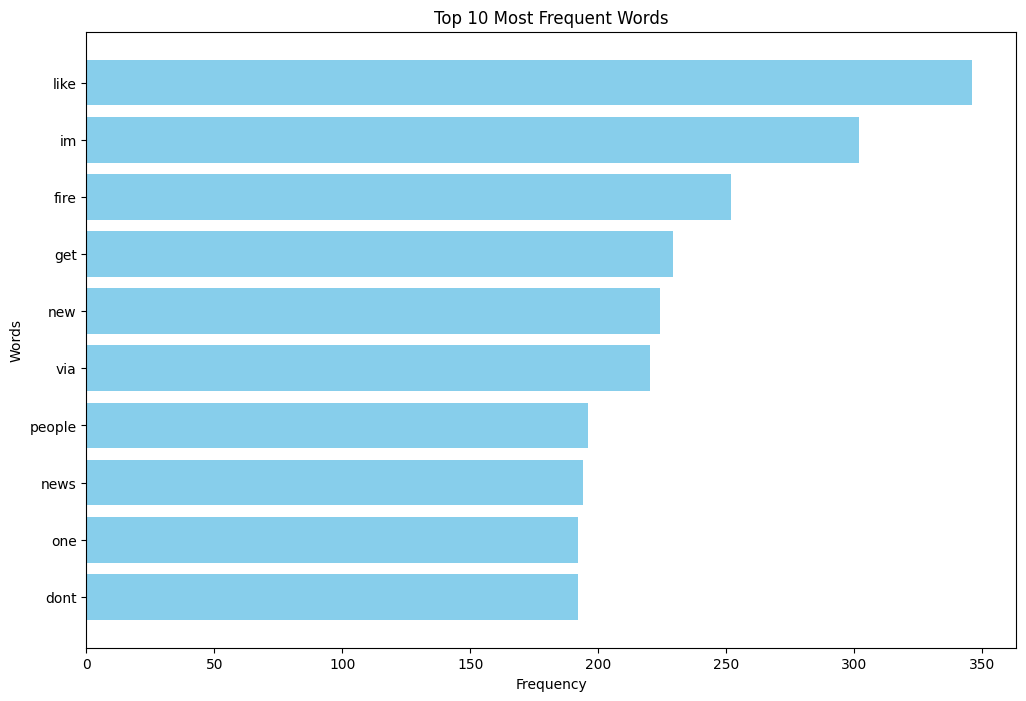

In [20]:
wordFreqDf = pd.DataFrame(wordCounts.items(), columns=['Word', 'Frequency'])
wordFreqDf = wordFreqDf.sort_values(by='Frequency', ascending=False)
print(wordFreqDf.head(10))
plt.figure(figsize=(12, 8))
plt.barh(wordFreqDf['Word'].head(10), wordFreqDf['Frequency'].head(10), color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis() 
plt.show()

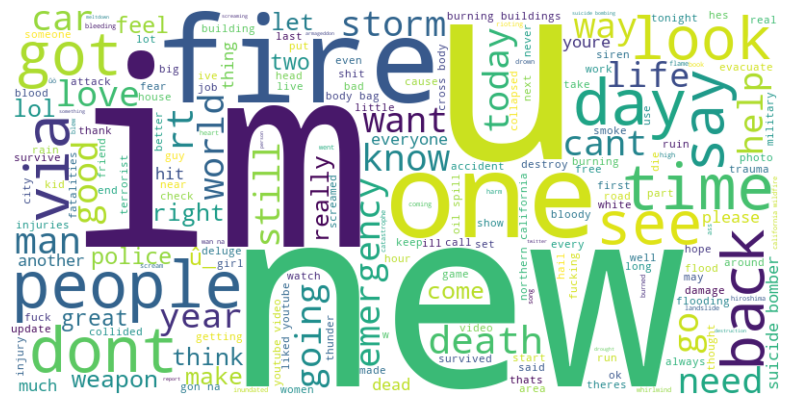

In [21]:
completeText = ' '.join(allWords)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(completeText)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

🔄 Generando 2-gramas...
📈 Mostrando los 10 2-gramas más frecuentes:
Label                   Disasters  No Disasters
2-gram                                         
(burning, buildings)         35.0          23.0
(california, wildfire)       34.0           NaN
(cross, body)                 1.0          38.0
(gon, na)                    11.0          32.0
(liked, youtube)              7.0          35.0
(northern, california)       41.0           NaN
(oil, spill)                 38.0           1.0
(suicide, bomber)            59.0           NaN
(wan, na)                     5.0          30.0
(youtube, video)              7.0          36.0


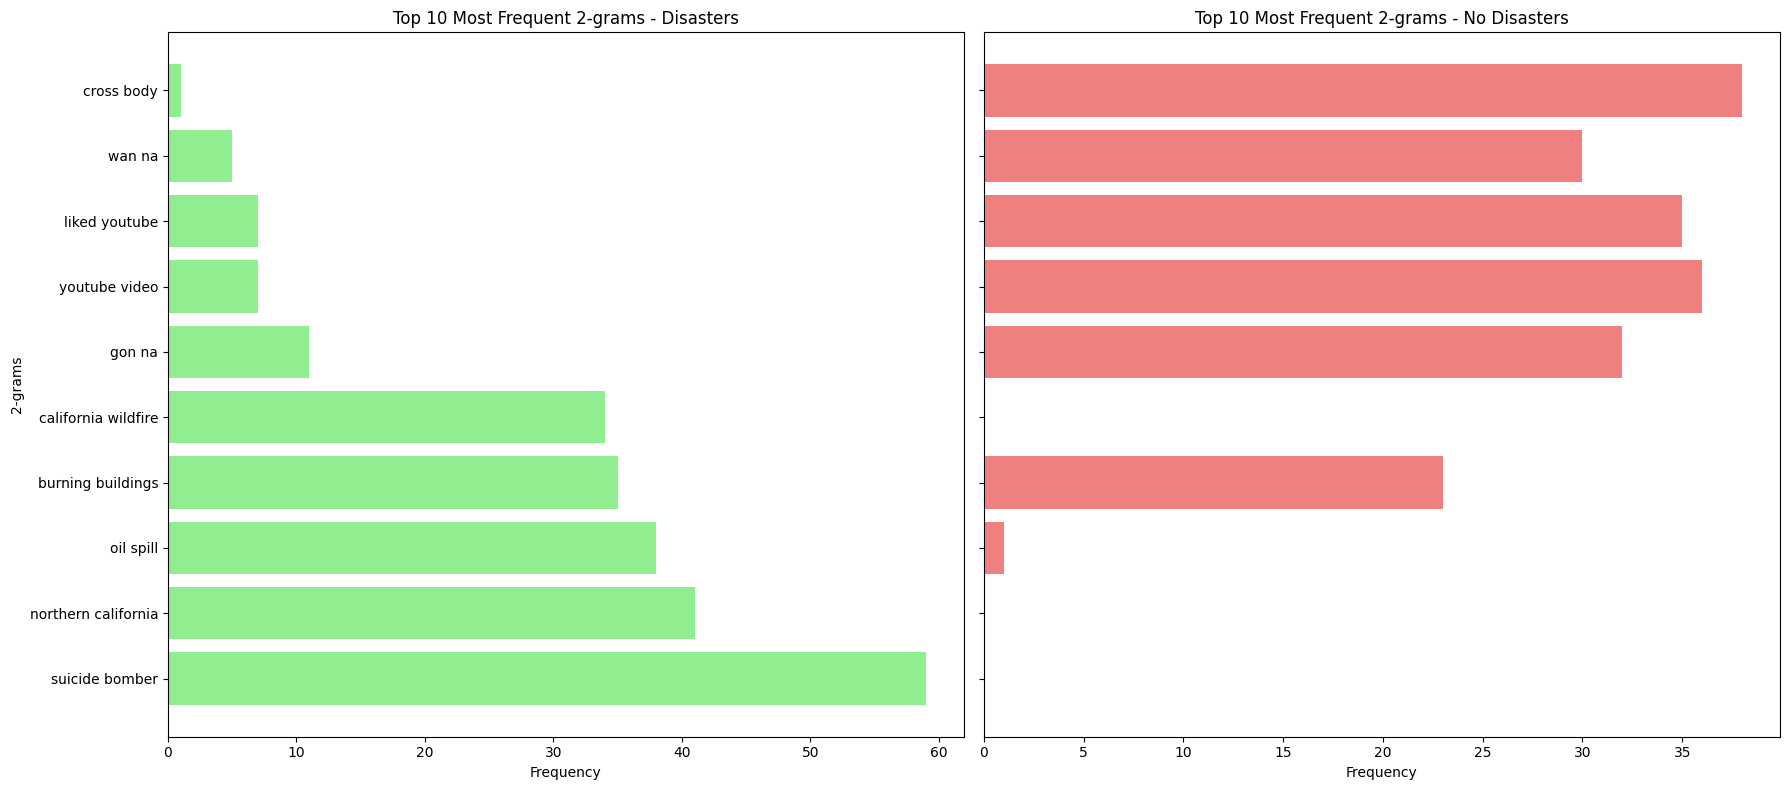

✅ Gráficos de 2-gramas generados.
🔄 Generando 3-gramas...
📈 Mostrando los 10 3-gramas más frecuentes:
Label                             Disasters  No Disasters
3-gram                                                   
(16yr, old, pkk)                       27.0           NaN
(bomber, detonated, bomb)              28.0           NaN
(homes, razed, northern)               28.0           NaN
(latest, homes, razed)                 28.0           NaN
(liked, youtube, video)                 7.0          35.0
(northern, california, wildfire)       29.0           NaN
(old, pkk, suicide)                    27.0           NaN
(pkk, suicide, bomber)                 28.0           NaN
(razed, northern, california)          27.0           NaN
(suicide, bomber, detonated)           30.0           NaN


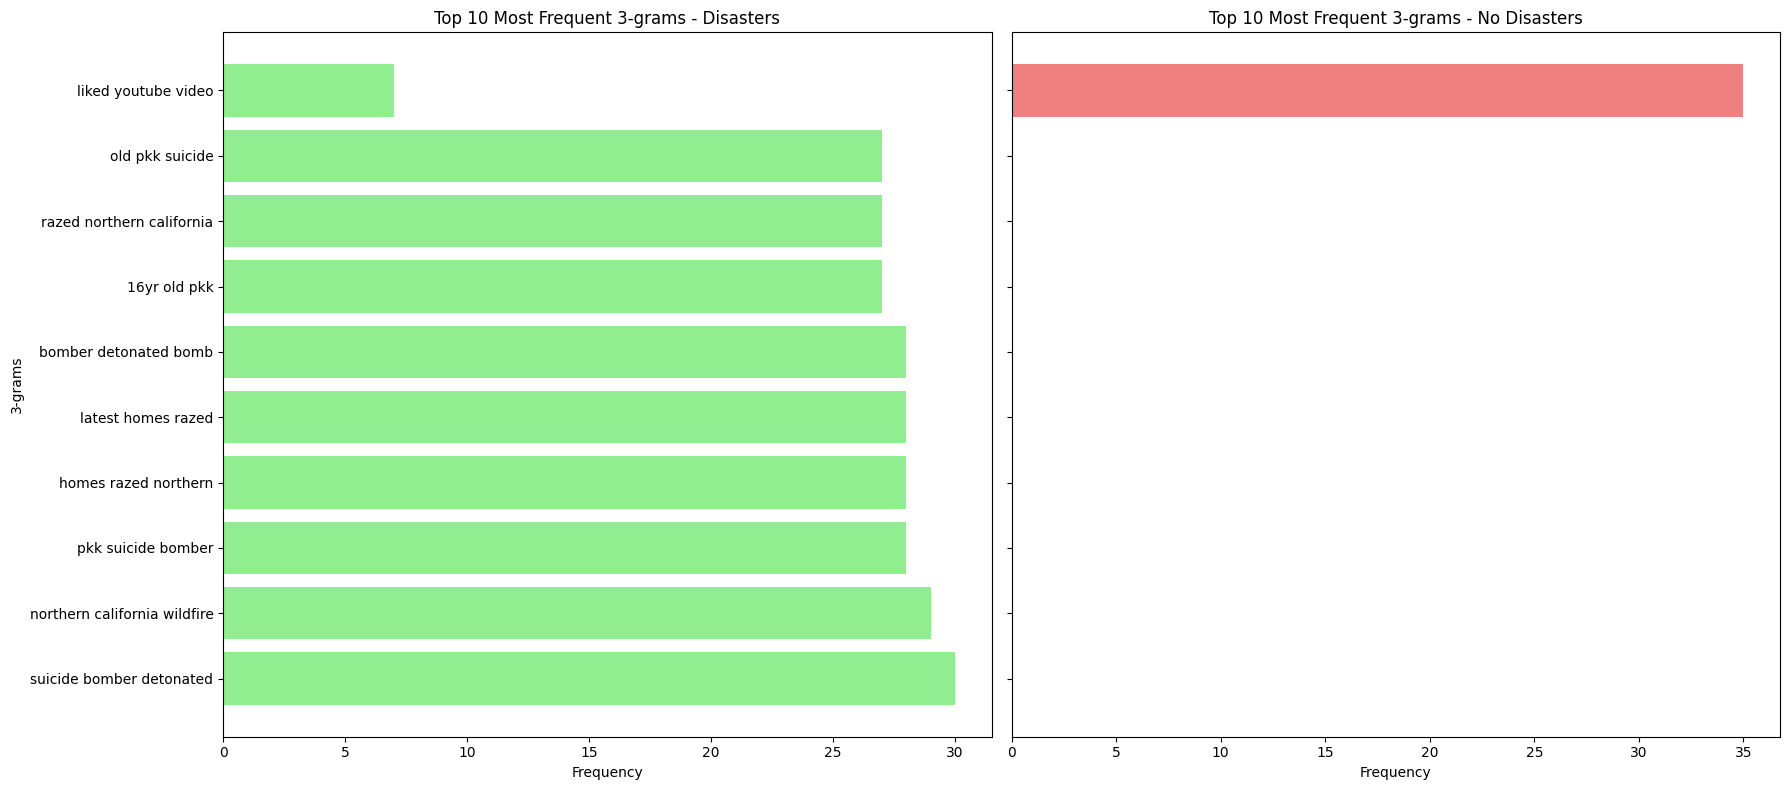

✅ Gráficos de 3-gramas generados.


In [22]:
def ngramAnalysis(tokenizedTextColumn, targetColumn, n=2):
    print(f"🔄 Generando {n}-gramas...")

    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def analyzeNgrams(texts, label):
        ngramsList = [ngram for tokens in texts for ngram in ngrams(tokens, n)]
        ngramCounts = Counter(ngramsList)
        ngramFreqDf = pd.DataFrame(ngramCounts.items(), columns=[f'{n}-gram', 'Frequency']).sort_values(by='Frequency', ascending=False)
        ngramFreqDf['Label'] = label
        return ngramFreqDf
    
    disasterNgramsDf = analyzeNgrams(disasterTweets, 'Disasters')
    nonDisasterNgramsDf = analyzeNgrams(nonDisasterTweets, 'No Disasters')
    
    topNgrams = pd.concat([disasterNgramsDf, nonDisasterNgramsDf]).groupby([f'{n}-gram'])['Frequency'].sum().sort_values(ascending=False).head(10).index
    topNgramsDf = pd.concat([disasterNgramsDf, nonDisasterNgramsDf])
    topNgramsDf = topNgramsDf[topNgramsDf[f'{n}-gram'].isin(topNgrams)]

    print(f"📈 Mostrando los 10 {n}-gramas más frecuentes:")
    print(topNgramsDf.groupby([f'{n}-gram', 'Label'])['Frequency'].sum().unstack())


    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    

    disasterSubset = topNgramsDf[topNgramsDf['Label'] == 'Disasters']
    axs[0].barh([' '.join(ngram) for ngram in disasterSubset[f'{n}-gram']], disasterSubset['Frequency'], color='lightgreen')
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel(f'{n}-grams')
    axs[0].set_title(f'Top 10 Most Frequent {n}-grams - Disasters')
    axs[0].invert_yaxis()
    
    nonDisasterSubset = topNgramsDf[topNgramsDf['Label'] == 'No Disasters']
    axs[1].barh([' '.join(ngram) for ngram in nonDisasterSubset[f'{n}-gram']], nonDisasterSubset['Frequency'], color='lightcoral')
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top 10 Most Frequent {n}-grams - No Disasters')
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()
    print(f"✅ Gráficos de {n}-gramas generados.")

ngramAnalysis(tokenizedText, dataTrain['target'], n=2)
ngramAnalysis(tokenizedText, dataTrain['target'], n=3)

### 📚 Inciso 5. Análisis exploratorio

#### ✖️ Palabra más repetidas

In [23]:
def mostFrequentWords(tokenizedTextColumn, targetColumn):
    print("🔄 Analizando palabras más frecuentes por categoría...")
    
    disasterTweets = tokenizedTextColumn[targetColumn == 1]
    nonDisasterTweets = tokenizedTextColumn[targetColumn == 0]
    
    def countWords(texts):
        wordsList = [word for tokens in texts for word in tokens]
        wordCounts = Counter(wordsList)
        return wordCounts
    
    disasterWordCounts = countWords(disasterTweets)
    nonDisasterWordCounts = countWords(nonDisasterTweets)
    disasterWordFreqDf = pd.DataFrame(disasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    nonDisasterWordFreqDf = pd.DataFrame(nonDisasterWordCounts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    print("📈 Palabra más frecuente en desastres:")
    print(disasterWordFreqDf.head(1))
    
    print("📈 Palabra más frecuente en no desastres:")
    print(nonDisasterWordFreqDf.head(1))
    
    return disasterWordFreqDf, nonDisasterWordFreqDf

disasterWordFreqDf, nonDisasterWordFreqDf = mostFrequentWords(tokenizedText, dataTrain['target'])

🔄 Analizando palabras más frecuentes por categoría...
📈 Palabra más frecuente en desastres:
   Word  Frequency
8  fire        180
📈 Palabra más frecuente en no desastres:
    Word  Frequency
24  like        253


#### ☁️ Nube de las palabras más frecuentes

🌐 Generando nube de palabras para Desastres...


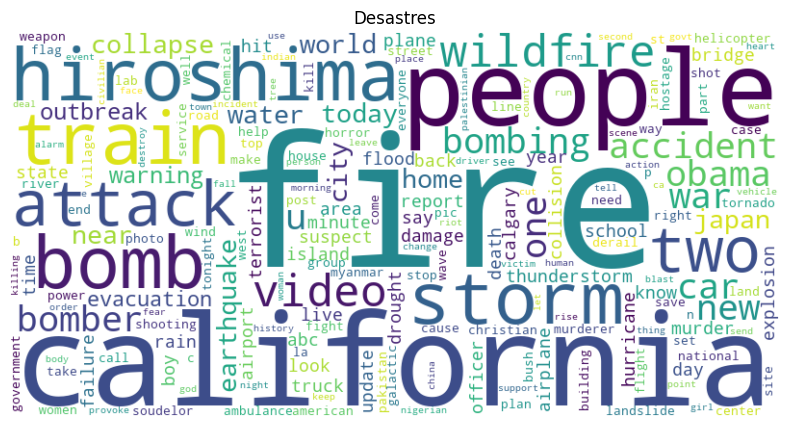

✅ Nube de palabras para Desastres generada.
🌐 Generando nube de palabras para No Desastres...


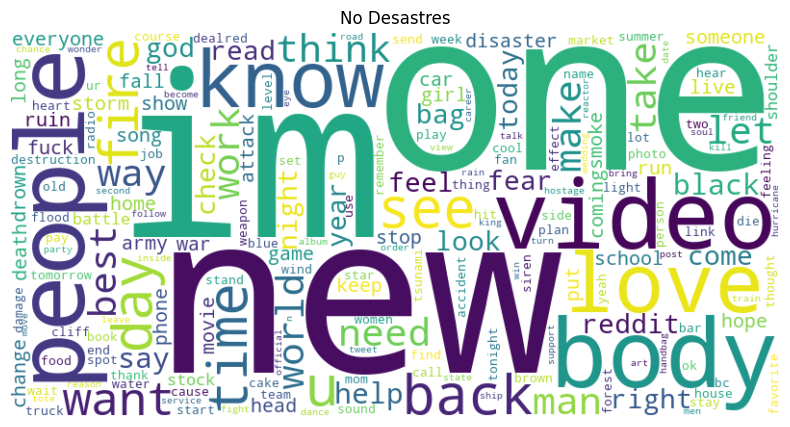

✅ Nube de palabras para No Desastres generada.


In [24]:
def plotWordCloud(wordFreqDf, title):
    print(f"🌐 Generando nube de palabras para {title}...")
    text = ' '.join(wordFreqDf['Word'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
    print(f"✅ Nube de palabras para {title} generada.")

plotWordCloud(disasterWordFreqDf, 'Desastres')
plotWordCloud(nonDisasterWordFreqDf, 'No Desastres')

#### 📊 Histogramas con las palabras más repetidas

📊 Generando histograma de palabras más frecuentes para Desastres...


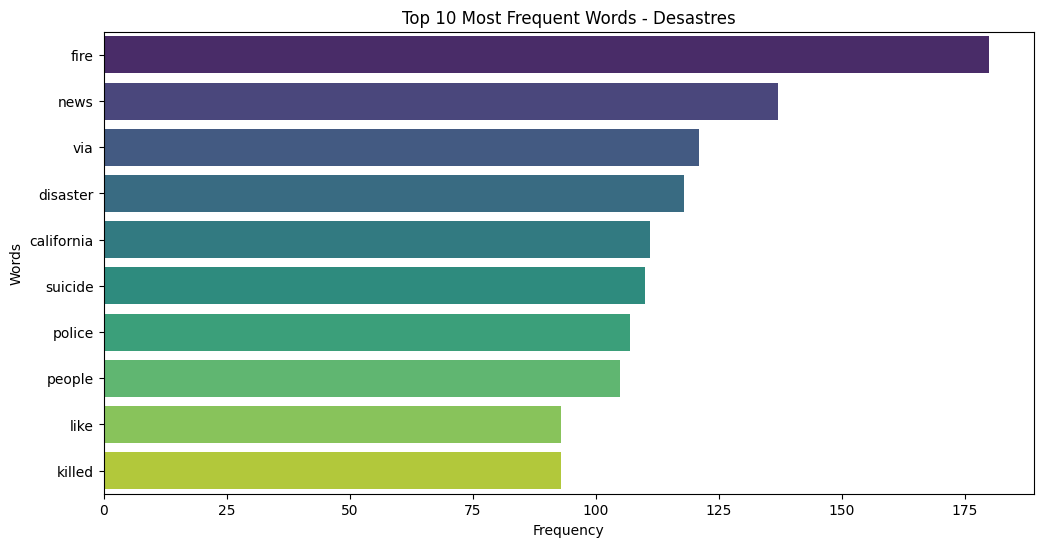

✅ Histograma de palabras más frecuentes para Desastres generado.
📊 Generando histograma de palabras más frecuentes para No Desastres...


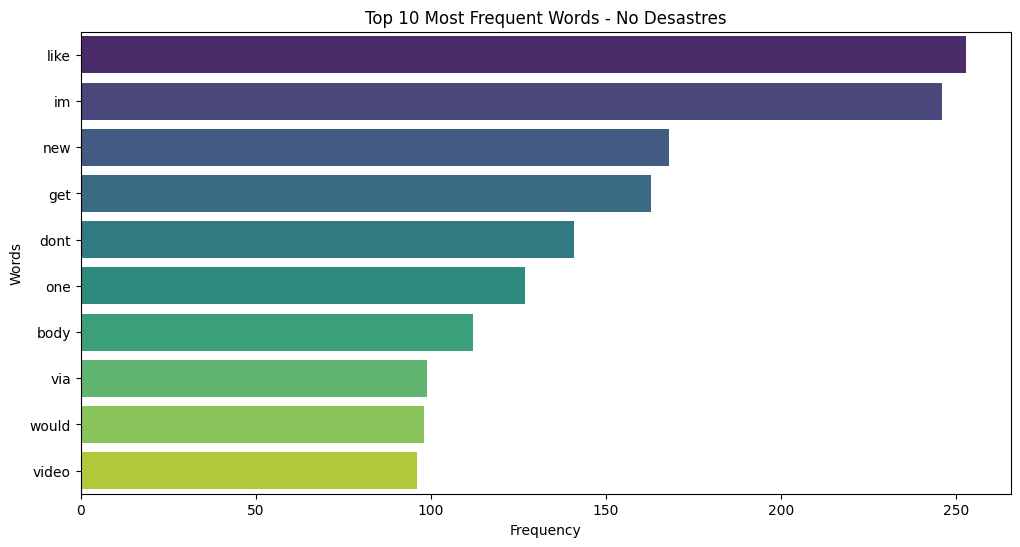

✅ Histograma de palabras más frecuentes para No Desastres generado.


In [25]:
def plotTopWordsHistogram(wordFreqDf, title):
    print(f"📊 Generando histograma de palabras más frecuentes para {title}...")
    topWords = wordFreqDf.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Word', data=topWords, hue='Word', palette='viridis', legend=False)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 10 Most Frequent Words - {title}')
    plt.show()
    
    print(f"✅ Histograma de palabras más frecuentes para {title} generado.")

plotTopWordsHistogram(disasterWordFreqDf, 'Desastres')
plotTopWordsHistogram(nonDisasterWordFreqDf, 'No Desastres')


🔍 Identificando palabras comunes en ambas categorías...
📚 Palabras comunes en ambas categorías:
{'numbers', 'snowstorm', 'beam', 'picked', 'ice', 'morning', 'admits', 'fights', 'paper', 'electricity', 'toward', 'chronicle', 'camping', 'genuine', 'targets', 'alarms', 'rainier', 'pls', 'betrayed', 'crew', 'director', 'bout', 'bring', 'mtvhottest', 'sets', 'killer', 'werent', 'robert', 'option', 'raised', 'family', 'pussy', 'reviews', 'sport', 'blue', 'grill', 'fast', 'westeros', 'document', 'razed', 'remember', 'frog', 'buried', 'field', 'losses', 'destruction', '4th', 'stop', 'minutes', 'pitch', 'australiaûªs', 'average', 'omfg', 'roll', 'chinaûªs', 'firetruck', 'victim', 'ûï', 'must', 'matter', 'aoms', 'hurt', 'telegraph', 'tonto', 'rights', 'chairs', 'causes', 'arrive', 'bal', 'run', 'spain', 'nursing', 'courts', '_', 'suffering', 'cia', 'settle', 'large', 'taken', 'fires', 'cnbc', 'barackobama', 'finding', 'witness', 'sicily', 'put', 'bar', 'treeporn', 'related', 'jailed', 'boys', 'a

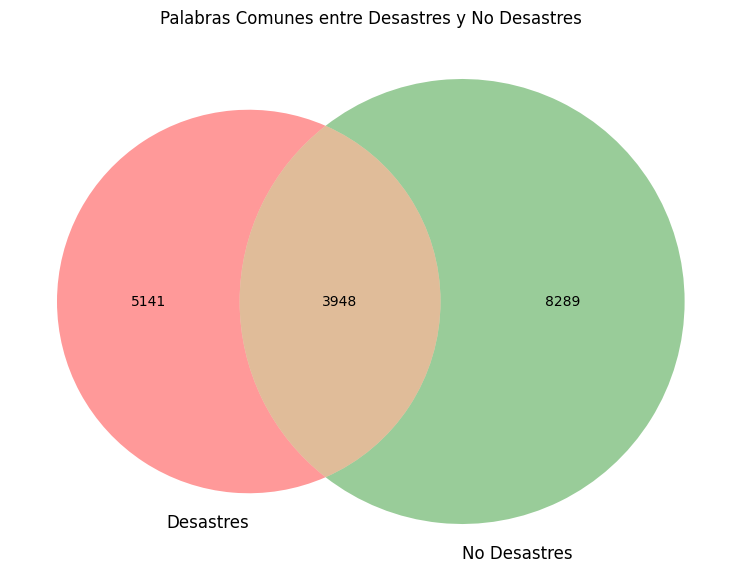

In [26]:
def commonWords(disasterWordFreqDf, nonDisasterWordFreqDf):
    print("🔍 Identificando palabras comunes en ambas categorías...")
    disasterWords = set(disasterWordFreqDf['Word'])
    nonDisasterWords = set(nonDisasterWordFreqDf['Word'])
    commonWords = disasterWords.intersection(nonDisasterWords)
    print("📚 Palabras comunes en ambas categorías:")
    print(commonWords)
    plt.figure(figsize=(10, 7))
    venn = venn2([disasterWords, nonDisasterWords], ('Desastres', 'No Desastres'))
    plt.title('Palabras Comunes entre Desastres y No Desastres')
    plt.show()

commonWords(disasterWordFreqDf, nonDisasterWordFreqDf)

### 😁 Inciso 6 - Clasificación de Tweets

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Descarga del léxico VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_words_by_sentiment(wordFreqDf):
    sentimentScores = {'Positive': [], 'Negative': [], 'Neutral': []}
    
    for word in wordFreqDf['Word']:
        sentiment = sia.polarity_scores(word) 
        
        if sentiment['compound'] >= 0.05:
            sentimentScores['Positive'].append((word, sentiment['compound']))
        elif sentiment['compound'] <= -0.05:
            sentimentScores['Negative'].append((word, sentiment['compound']))
        else:
            sentimentScores['Neutral'].append((word, sentiment['compound']))
    
    return sentimentScores, sentiment


disasterSentiment, sentiment = classify_words_by_sentiment(disasterWordFreqDf)
nonDisasterSentiment, sentiment = classify_words_by_sentiment(nonDisasterWordFreqDf)

print("\n🔍 Sentimientos en palabras de desastres reales:")
print("Positivas:", len(disasterSentiment['Positive']))
print("Negativas:", len(disasterSentiment['Negative']))
print("Neutrales:", len(disasterSentiment['Neutral']))

print("\n🔍 Sentimientos en palabras de no desastres:")
print("Positivas:", len(nonDisasterSentiment['Positive']))
print("Negativas:", len(nonDisasterSentiment['Negative']))
print("Neutrales:", len(nonDisasterSentiment['Neutral']))



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



🔍 Sentimientos en palabras de desastres reales:
Positivas: 337
Negativas: 523
Neutrales: 8229

🔍 Sentimientos en palabras de no desastres:
Positivas: 533
Negativas: 623
Neutrales: 11081


In [28]:
sentences = textWithoutStopwords.tolist()
textWithoutStopwords

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    aria_ahrary thetawniest control wild fires cal...
7610                           m1   utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Descargar léxico VADER si no está descargado
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

def analyze_tweet_sentiment(tweet):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    # Tokenizar el tweet para obtener palabras individuales
    words = tweet.split()
    
    # Recorremos cada palabra del tweet
    for word in words:
        sentiment = sia.polarity_scores(word)  # Obtener el puntaje de sentimiento de cada palabra
        
        if sentiment['compound'] >= 0.05:  # Si es positivo
            positive_count += 1
        elif sentiment['compound'] <= -0.05:  # Si es negativo
            negative_count += 1
        else:  # Si es neutral
            neutral_count += 1
    
    total_words = len(words)
    
    if total_words == 0:
        return "Neutral"  # Si el tweet no tiene palabras, lo consideramos neutral
    
    # Proporción de palabras positivas, negativas y neutras
    positive_percentage = (positive_count / total_words) * 100
    negative_percentage = (negative_count / total_words) * 100
    neutral_percentage = (neutral_count / total_words) * 100
    
    # Determinar la clasificación general
    if positive_percentage > negative_percentage:
        sentiment = f"Positivo ({positive_percentage:.2f}%)"
    elif negative_percentage > positive_percentage:
        sentiment = f"Negativo ({negative_percentage:.2f}%)"
    else:
        sentiment = f"Neutral ({neutral_percentage:.2f}%)"
    
    return sentiment, positive_count, negative_count, neutral_count

# Aplicamos la función a cada tweet en la lista
tweet_list = [
    analyze_tweet_sentiment(tweet) for tweet in textWithoutStopwords
]

# Mostramos los resultados
for i, (sentiment, pos_count, neg_count, neu_count) in enumerate(tweet_list[:5]):
    print(f" \n🐦 Tweet {i+1}: {textWithoutStopwords[i]}")
    print(f"Sentimiento: {sentiment}")
    print(f"Palabras positivas: {pos_count}")
    print(f"Palabras negativas: {neg_count}")
    print(f"Palabras neutrales: {neu_count}")
    print()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lijv1.LINDA_HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 
🐦 Tweet 1: deeds reason earthquake may allah forgive us
Sentimiento: Positivo (14.29%)
Palabras positivas: 1
Palabras negativas: 0
Palabras neutrales: 6

 
🐦 Tweet 2: forest fire near la ronge sask canada
Sentimiento: Negativo (14.29%)
Palabras positivas: 0
Palabras negativas: 1
Palabras neutrales: 6

 
🐦 Tweet 3: residents asked shelter place notified officers evacuation shelter place orders expected
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 11

 
🐦 Tweet 4: people receive wildfires evacuation orders california
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 6

 
🐦 Tweet 5: got sent photo ruby alaska smoke wildfires pours school
Sentimiento: Neutral (100.00%)
Palabras positivas: 0
Palabras negativas: 0
Palabras neutrales: 9



In [30]:
data = dataTrain.copy()
data['textWithoutStopwords'] = textWithoutStopwords



In [31]:
from tabulate import tabulate

data[['Sentiment', 'Positive_Count', 'Negative_Count', 'Neutral_Count']] = data['textWithoutStopwords'].apply(analyze_tweet_sentiment).apply(pd.Series)

# Agregar columna para la categoría
data['Category'] = data['target'].apply(lambda x: 'Desastre' if x == 1 else 'No Desastre')

# Top 10 tweets más negativos en general
top_10_negative = data.nlargest(10, 'Negative_Count')[['textWithoutStopwords', 'Negative_Count', 'Category']]
top_10_positive = data.nlargest(10, 'Positive_Count')[['textWithoutStopwords', 'Positive_Count', 'Category']]

# Mostrar resultados usando formato 'grid'
print("\n🔍 Los 10 tweets más negativos:")
print(tabulate(top_10_negative, headers='keys', tablefmt='fancy_grid', showindex=False))
print("\n🔍 Los 10 tweets más positivos:")
print(tabulate(top_10_positive, headers='keys', tablefmt='fancy_grid', showindex=False))

# Comparar el sentimiento promedio
disaster_tweets_df = data[data['target'] == 1]
non_disaster_tweets_df = data[data['target'] == 0]

avg_negative_disaster = disaster_tweets_df['Negative_Count'].mean()
avg_negative_non_disaster = non_disaster_tweets_df['Negative_Count'].mean()

# Convertir los promedios a porcentaje
avg_negative_disaster_percentage = avg_negative_disaster * 100 / disaster_tweets_df['textWithoutStopwords'].str.split().apply(len).mean()
avg_negative_non_disaster_percentage = avg_negative_non_disaster * 100 / non_disaster_tweets_df['textWithoutStopwords'].str.split().apply(len).mean()

# Mostrar los promedios en porcentaje
print(f"\n🔍 Promedio de palabras negativas en tweets de desastres: {avg_negative_disaster_percentage:.2f}%")
print(f"🔍 Promedio de palabras negativas en tweets de no desastres: {avg_negative_non_disaster_percentage:.2f}%")

if avg_negative_disaster_percentage > avg_negative_non_disaster_percentage:
    print("Los tweets de desastres reales son más negativos que los de la otra categoría.")
else:
    print("Los tweets de desastres reales no son más negativos que los de la otra categoría.")


🔍 Los 10 tweets más negativos:
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════╤═════════════╕
│ textWithoutStopwords                                                                                                                       │   Negative_Count │ Category    │
╞════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════════╪═════════════╡
│ wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck                                                              │               13 │ No Desastre │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼─────────────┤
│ bomb crash loot riot emergency pipe bomb nuclear chemical spill gas ricin leak violenc

### 🧠 Inciso 8. Modelo CNN con negatividad

#### 🗂️ Dividir en entrenamiento y prueba (80 - 20).

In [41]:
# Datos de ejemplo
sentences = textWithoutStopwords.tolist()
targets = dataTrain['target'].tolist()
testSentences = dataTest['text'].tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
trainingSize = int(len(sentences) * 0.80)
trainingSentences = sentences[:trainingSize]
testingSentences = sentences[trainingSize:]
trainingTargets = targets[:trainingSize]
testingTargets = targets[trainingSize:]

# Convertir a arrays
trainingTargetsArray = np.array(trainingTargets)
testingTargetsArray = np.array(testingTargets)

# Crear el array para las etiquetas
training_targets_array = np.array(trainingTargets)
testing_targets_array = np.array(testingTargets)

#### 🖼️ Tokenización y aplicación de padding.

In [33]:
# Tokenización y padding
tokenizer = Tokenizer(num_words=500, oov_token='<OOV>')
tokenizer.fit_on_texts(trainingSentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(trainingSentences)
training_padded = pad_sequences(training_sequences, maxlen=40, padding='post', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(testingSentences)
testing_padded = pad_sequences(testing_sequences, maxlen=40, padding='post', truncating='post')
main_test_sequence = tokenizer.texts_to_sequences(testSentences)
main_test_padded = pad_sequences(main_test_sequence, maxlen=40, padding='post', truncating='post')

# Crear una variable de negatividad para el conjunto de entrenamiento y prueba
negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sentences]
negativity_scores_train = negativity_scores[:trainingSize]
negativity_scores_test = negativity_scores[trainingSize:]

# Convertir la variable de negatividad a arrays
training_negativity_array = np.array(negativity_scores_train).reshape(-1, 1)
testing_negativity_array = np.array(negativity_scores_test).reshape(-1, 1)

In [34]:
# Función para agregar ruido a la capa de embedding
def add_embedding_noise(embedding, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(embedding), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    return embedding + noise


In [37]:
# Crear una variable de negatividad para el conjunto de entrenamiento y prueba
negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sentences]
negativity_scores_train = negativity_scores[:trainingSize]
negativity_scores_test = negativity_scores[trainingSize:]

# Convertir la variable de negatividad a arrays
training_negativity_array = np.array(negativity_scores_train).reshape(-1, 1)
testing_negativity_array = np.array(negativity_scores_test).reshape(-1, 1)


def create_combined_input(text_sequences, negativity_array):
    # Concatenar secuencias de texto y negatividad
    combined = np.hstack([text_sequences, np.repeat(negativity_array, text_sequences.shape[1], axis=1)])
    return combined

# Convertir las secuencias de texto y negatividad a arrays
training_padded_combined = create_combined_input(training_padded, training_negativity_array)
testing_padded_combined = create_combined_input(testing_padded, testing_negativity_array)



In [39]:
# Definir el modelo
input_text = layers.Input(shape=(40,))
input_negativity = layers.Input(shape=(1,))

embedding_layer = layers.Embedding(500, 16, input_length=40)(input_text)
conv1 = layers.Conv1D(128, 5, activation='relu')(embedding_layer)
pool1 = layers.MaxPooling1D(pool_size=4)(conv1)
conv2 = layers.Conv1D(64, 5, activation='relu')(pool1)
pool2 = layers.MaxPooling1D(pool_size=4)(conv2)
flatten_layer = layers.Flatten()(pool2)

# Concatenar la salida de la red convolucional con la variable de negatividad
concat_layer = layers.concatenate([flatten_layer, input_negativity])

dense_layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concat_layer)
dense_layer = layers.Dropout(0.5)(dense_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

# Crear el modelo
model = Model(inputs=[input_text, input_negativity], outputs=output_layer)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 40, 16)    │      8,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 36, 128)   │     10,368 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 9, 128)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5, 64)     │     41,024 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 64)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 64)        │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 65)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,224 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,681 (248.75 KB)

 Trainable params: 63,681 (248.75 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Entrenar el modelo
history = model.fit(
    [training_padded, training_negativity_array],  # Entradas: texto y negatividad
    training_targets_array,                       # Salida: etiquetas
    epochs=15,                                     # Número de épocas
    validation_data=([testing_padded, testing_negativity_array], testing_targets_array)  # Datos de validación
)


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5809 - loss: 0.7148 - val_accuracy: 0.7203 - val_loss: 0.6062
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7539 - loss: 0.5302 - val_accuracy: 0.7452 - val_loss: 0.5337
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8192 - loss: 0.4322 - val_accuracy: 0.7413 - val_loss: 0.5307
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8214 - loss: 0.4268 - val_accuracy: 0.7308 - val_loss: 0.5536
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8184 - loss: 0.4205 - val_accuracy: 0.7269 - val_loss: 0.5945
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8344 - loss: 0.4027 - val_accuracy: 0.7452 - val_loss: 0.5445
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8557 - loss: 0.3532 - val_accuracy: 0.7426 - val_loss: 0.5711
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8671 - loss: 0.3345 - val_accuracy: 0

In [43]:
test_loss, test_accuracy = model.evaluate([testing_padded, testing_negativity_array], testing_targets_array)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7259 - loss: 0.8037
Test Loss: 0.8211
Test Accuracy: 0.7236


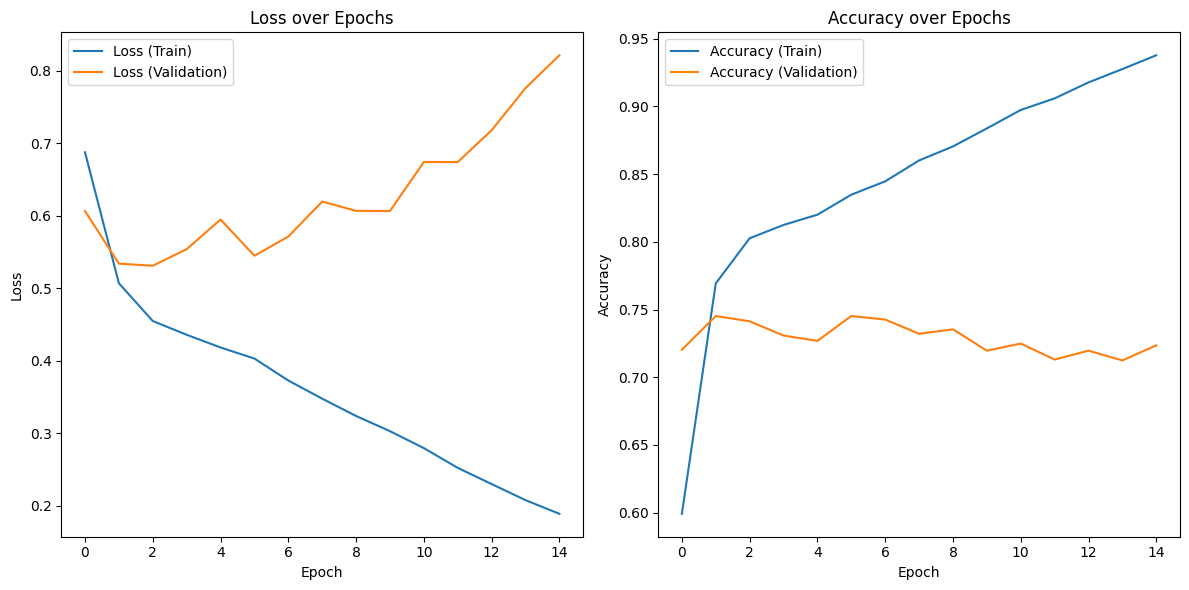

In [44]:
import matplotlib.pyplot as plt

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 6))

# Graficar la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# Ejemplo de primeros 10 tweets de prueba
sample_tweets = dataTest['text'].head(10).tolist()

# Tokenizar y aplicar padding
sample_sequences = tokenizer.texts_to_sequences(sample_tweets)
sample_padded = pad_sequences(sample_sequences, maxlen=40, padding='post', truncating='post')

# Calcular la negatividad para los primeros 10 tweets
sample_negativity_scores = [analyze_tweet_sentiment(tweet)[1] for tweet in sample_tweets]
sample_negativity_array = np.array(sample_negativity_scores).reshape(-1, 1)

# Realizar predicciones
predictions = model.predict([sample_padded, sample_negativity_array])

# Convertir predicciones a etiquetas
predicted_classes = (predictions > 0.5).astype(int)  # Umbral para clasificación binaria

# Mostrar resultados
for i, tweet in enumerate(sample_tweets):
    sentiment = 'Desastre' if predicted_classes[i] == 1 else 'No Desastre'
    print(f"Tweet {i+1}: {tweet}")
    print(f"Predicción: {sentiment}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Tweet 1: Just happened a terrible car crash
Predicción: Desastre

Tweet 2: Heard about #earthquake is different cities, stay safe everyone.
Predicción: Desastre

Tweet 3: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicción: Desastre

Tweet 4: Apocalypse lighting. #Spokane #wildfires
Predicción: No Desastre

Tweet 5: Typhoon Soudelor kills 28 in China and Taiwan
Predicción: No Desastre

Tweet 6: We're shaking...It's an earthquake
Predicción: Desastre

Tweet 7: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Predicción: No Desastre

Tweet 8: Hey! How are you?
Predicción: No Desastre

Tweet 9: What a nice hat?
Predicción: No Desastre

Tweet 10: Fuck off!
Predicción: No Desastre



# 🥫 Ejercicio 2

In [8]:
data = pd.read_csv('GrammarandProductReviews.csv')
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427
